In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import os
# import pandas as pd
from glob import glob
#import climpredNEW.climpred 
#from climpredNEW.climpred.options import OPTIONS
from climpred.options import OPTIONS
import climpred
import pickle
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from scipy.stats import rankdata
import bottleneck as bn
import scipy.stats as stats

from function import preprocessUtils as putils
from function import masks
from function import verifications
from function import funs as f
from function import conf
from function import loadbias

from function.taylorDiagram import TaylorDiagram
import numpy as NP
import matplotlib.pyplot as PLT


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


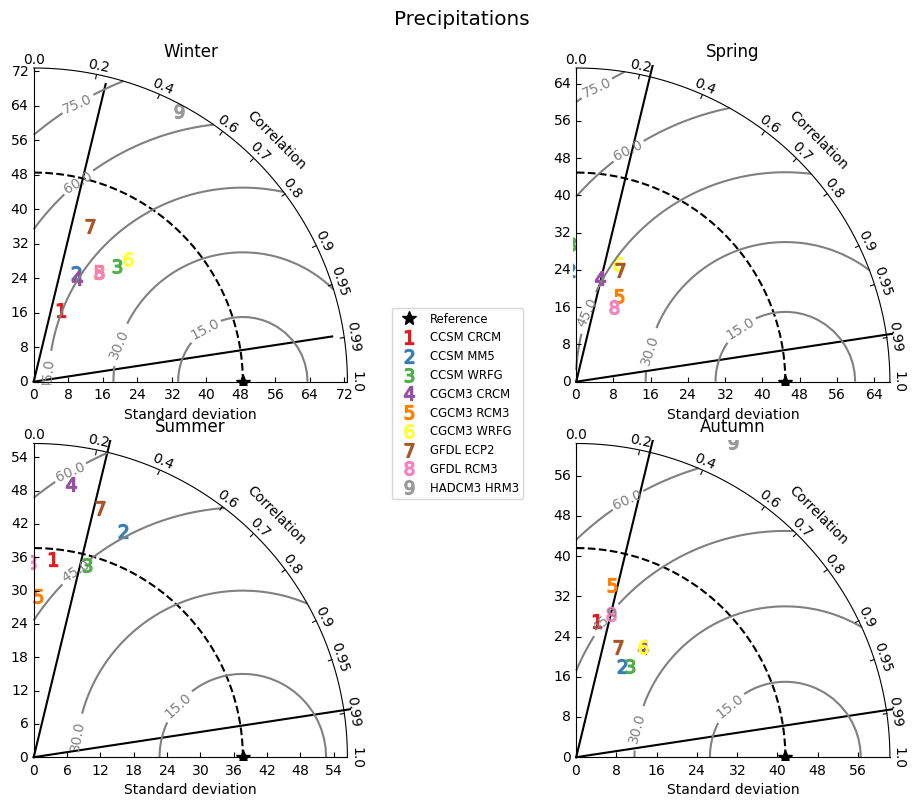

In [3]:
#!/usr/bin/env python

__version__ = "Time-stamp: <2018-12-06 11:55:22 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

"""
Example of use of TaylorDiagram. Illustration dataset courtesy of Michael
Rawlins.

Rawlins, M. A., R. S. Bradley, H. F. Diaz, 2012. Assessment of regional climate
model simulation estimates over the Northeast United States, Journal of
Geophysical Research (2012JGRD..11723112R).
"""

# Reference std
stdrefs = dict(winter=48.491,
               spring=44.927,
               summer=37.664,
               autumn=41.589)

# Sample std,rho: Be sure to check order and that correct numbers are placed!
samples = dict(winter=[[17.831, 0.360, "CCSM CRCM"],
                       [27.062, 0.360, "CCSM MM5"],
                       [33.125, 0.585, "CCSM WRFG"],
                       [25.939, 0.385, "CGCM3 CRCM"],
                       [29.593, 0.509, "CGCM3 RCM3"],
                       [35.807, 0.609, "CGCM3 WRFG"],
                       [38.449, 0.342, "GFDL ECP2"],
                       [29.593, 0.509, "GFDL RCM3"],
                       [71.215, 0.473, "HADCM3 HRM3"]],
               spring=[[32.174, -0.262, "CCSM CRCM"],
                       [24.042, -0.055, "CCSM MM5"],
                       [29.647, -0.040, "CCSM WRFG"],
                       [22.820, 0.222, "CGCM3 CRCM"],
                       [20.505, 0.445, "CGCM3 RCM3"],
                       [26.917, 0.332, "CGCM3 WRFG"],
                       [25.776, 0.366, "GFDL ECP2"],
                       [18.018, 0.452, "GFDL RCM3"],
                       [79.875, 0.447, "HADCM3 HRM3"]],
               summer=[[35.863, 0.096, "CCSM CRCM"],
                       [43.771, 0.367, "CCSM MM5"],
                       [35.890, 0.267, "CCSM WRFG"],
                       [49.658, 0.134, "CGCM3 CRCM"],
                       [28.972, 0.027, "CGCM3 RCM3"],
                       [60.396, 0.191, "CGCM3 WRFG"],
                       [46.529, 0.258, "GFDL ECP2"],
                       [35.230, -0.014, "GFDL RCM3"],
                       [87.562, 0.503, "HADCM3 HRM3"]],
               autumn=[[27.374, 0.150, "CCSM CRCM"],
                       [20.270, 0.451, "CCSM MM5"],
                       [21.070, 0.505, "CCSM WRFG"],
                       [25.666, 0.517, "CGCM3 CRCM"],
                       [35.073, 0.205, "CGCM3 RCM3"],
                       [25.666, 0.517, "CGCM3 WRFG"],
                       [23.409, 0.353, "GFDL ECP2"],
                       [29.367, 0.235, "GFDL RCM3"],
                       [70.065, 0.444, "HADCM3 HRM3"]])

# Colormap (see http://www.scipy.org/Cookbook/Matplotlib/Show_colormaps)
colors = PLT.matplotlib.cm.Set1(NP.linspace(0,1,len(samples['winter'])))

# Here set placement of the points marking 95th and 99th significance
# levels. For more than 102 samples (degrees freedom > 100), critical
# correlation levels are 0.195 and 0.254 for 95th and 99th
# significance levels respectively. Set these by eyeball using the
# standard deviation x and y axis.

#x95 = [0.01, 0.68] # For Tair, this is for 95th level (r = 0.195)
#y95 = [0.0, 3.45]
#x99 = [0.01, 0.95] # For Tair, this is for 99th level (r = 0.254)
#y99 = [0.0, 3.45]

x95 = [0.05, 13.9] # For Prcp, this is for 95th level (r = 0.195)
y95 = [0.0, 71.0]
x99 = [0.05, 19.0] # For Prcp, this is for 99th level (r = 0.254)
y99 = [0.0, 70.0]

rects = dict(winter=221,
             spring=222,
             summer=223,
             autumn=224)

fig = PLT.figure(figsize=(11,8))
fig.suptitle("Precipitations", size='x-large')

for season in ['winter','spring','summer','autumn']:

    dia = TaylorDiagram(stdrefs[season], fig=fig, rect=rects[season],
                        label='Reference')

    dia.ax.plot(x95,y95,color='k')
    dia.ax.plot(x99,y99,color='k')

    # Add samples to Taylor diagram
    for i,(stddev,corrcoef,name) in enumerate(samples[season]):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       #mfc='k', mec='k', # B&W
                       mfc=colors[i], mec=colors[i], # Colors
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    # Tricky: ax is the polar ax (used for plots), _ax is the
    # container (used for layout)
    dia._ax.set_title(season.capitalize())

# Add a figure legend and title. For loc option, place x,y tuple inside [ ].
# Can also use special options here:
# http://matplotlib.sourceforge.net/users/legend_guide.html

fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='center')

fig.tight_layout()

PLT.savefig('test_taylor_4panel.png')
PLT.show()
